<a class="anchor" id="toc-go-back"></a>
# Assignment 3: Day-ahead scheduling from the perspective of the system operator

### Table of Contents
* [1. Loading the data](#data-loading)
* [2. Setup optimization problem](#optimziation-problem-setup)
* [3. Running the optimization model ](#run-optimization)
* [4. Can we solve the problem using machine learning?](#machine-learning)
* [5. Extra ](#extra)

First of all, we refer to the hand-in for an in-depth description of the problem formulation and the optimization problem. This notebooks focuses on implementing the model using ```Gurobipy``` and an additional part using machine learning. 

We start by loading the relevant modules.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import gurobipy as grb

In [2]:
DATA_DIR = Path('../data')

<a class="anchor" id="data-loading"></a>
## 1. Loading the data

We initially load the data files given to us with the assignment description. This will later on be used as input to the optimization model from which we can then find the optimal values of the decision variables.

In [3]:
# Load data files from csv-files
pmax    = pd.read_csv(DATA_DIR / 'pgmax.csv')
pmin    = pd.read_csv(DATA_DIR / 'pgmin.csv')
ru      = pd.read_csv(DATA_DIR / 'ramp.csv')
UT      = pd.read_csv(DATA_DIR / 'lu.csv')
DT      = pd.read_csv(DATA_DIR / 'ld.csv')    
demand  = pd.read_csv(DATA_DIR / 'Demand.csv', sep=';')   
c_op    = pd.read_csv(DATA_DIR / 'cost_op.csv') 
c_st    = pd.read_csv(DATA_DIR / 'cost_st.csv') 
PTDF    = pd.read_csv(DATA_DIR / 'PTDF.csv', sep=';') 
busgen  = pd.read_csv(DATA_DIR / 'busgen.csv', sep=';')
busload = pd.read_csv(DATA_DIR / 'busload.csv', sep=';')
fmax    = pd.read_csv(DATA_DIR / 'fmax.csv')

# 
Hg      = pd.DataFrame(np.dot(PTDF, busgen), index=[f'Line {i+1}' for i in range(PTDF.shape[0])], columns=[f'Gen {i+1}' for i in range(busgen.shape[1])])
Hl      = pd.DataFrame(np.dot(PTDF, busload), index=[f'Line {i+1}' for i in range(PTDF.shape[0])], columns=[f'Load {i+1}' for i in range(busload.shape[1])])

# Load load profile samples
samples = pd.read_csv(DATA_DIR / 'samples.csv', header=None)

With the data set loaded, we can now define the basics underlying the optimization problem - thus, we start by defining the numerical values of the parameters.

In [4]:
N_g     = busgen.shape[1]   # the number of generator units
N_t     = demand.shape[0]   # next 24 hours
N_load  = busload.shape[1]  # the number of load buses
N_lines = PTDF.shape[0]     # the number of transmission lines

<a class="anchor" id="optimization-problem-setup"></a>
## 2. Setup optimization problem

Differences between the hand-in and the proposed formula from class:
1. start-up cost is deterministic and should not be optimized for (i.e. input parameter and not decision variable)
2. demand is additionally indexed by time for the flow constraint
3. the start-up constraint is added by specifying an on/off variable for each unit at each time, $b$.

Now, we are ready to define the decision variables of the optimization problem. These relate to the start-up status and production of generator units at each time step of the day. We additionally include a variable for denoting the on/off status. As we are given a data file for start-up costs for each generation unit, we approach the problem with the start-up cost being time-independent and consider it as an input rather than a decision variable.

Next, we add the constraints to the optimization model. Overall these concern:
1) Power balance equation, i.e. the total production must equal the total demand. Here, we add the concept of slack variable for feasibility - i.e. making sure that the problem can be solved even if in some cases the demand is not met.
2) Generation limits, ensuring that the generator units do not produce more than their maximum capacity.
3) Ramp-up and ramp-down constraints, ensuring...
4) Line technical limits, ensuring that the flow between busses does not exceed the maximum capacity of the line.
5) Minimum on/off times.
6) Start-up constraints for turning on a generator unit (i.e. the unit must be off in the previous time step).

Lastly, we define the objective function for the optimization problem. This is defined as minimizing the total cost - i.e. production cost and start-up cost. In this case, we assume deterministic start-up costs for each generator unit - in other words, we assume that they are time-independent.

These three steps have been implemented in a wrapper object related to the 118-bus system, namely the ```BUS118```-class defined below.

In [5]:
class BUS118:
    
    def __init__(self, 
        N_g, N_t, N_load, N_lines, 
        demand,
        pmin, pmax,
        Hg, Hl, fmax,
        UT, DT, ru,
        c_op, c_st,
    ):
        
        # Define numerical parameters
        self.N_g        = N_g
        self.N_t        = N_t
        self.N_load     = N_load
        self.N_lines    = N_lines

        # Define input data
        self.demand     = demand
        self.pmin       = pmin
        self.pmax       = pmax
        self.fmax       = fmax
        self.UT         = UT
        self.DT         = DT
        self.ru         = ru
        self.c_op       = c_op
        self.c_st       = c_st
        self.Hg         = Hg
        self.Hl         = Hl

    def define_decision_variables(self):
        # Add variables for each generator unit at each time step for specifying on/off and start-up status
        self.b      = self.model.addVars(N_g, N_t, vtype=grb.GRB.BINARY, name='b')
        self.u      = self.model.addVars(N_g, N_t, vtype=grb.GRB.BINARY, name='u')
        
        # Add variable denoting the power output of each generator unit at each time step
        self.p      = self.model.addVars(N_g, N_t, vtype=grb.GRB.CONTINUOUS, name='p')

        # We add slack variables for ensuring feasability of the power balance equations
        self.eps    = self.model.addVars(N_t, 1, vtype=grb.GRB.CONTINUOUS, name='eps')
        self.delta  = self.model.addVars(N_t, 1, vtype=grb.GRB.CONTINUOUS, name='delta')

        # Make variable updates effective
        self.model.update()
    
    def define_constraints(self, load_profile):
        
        self.demand_profile = (self.demand * load_profile)

        for t in tqdm(range(N_t), desc='Adding constraints...'):
            ### POWER BALANCE EQUATION ###
            # Add power balance constraints for each time step
            self.model.addConstr(grb.quicksum(self.p[g_n, t] for g_n in range(self.N_g)) == grb.quicksum(self.demand_profile.iloc[t, n] for n in range(self.N_load)) + self.eps[t, 0] - self.delta[t, 0], name=f'power_balance[{t}]')
            
            # Add positive constraints for the slack variables
            self.model.addConstr(self.eps[t, 0] >= 0)
            self.model.addConstr(self.delta[t, 0] >= 0)

            for g in range(self.N_g):
                
                ### GENERATION LIMITS ###
                self.model.addConstr(self.b[g, t] * self.pmin.iloc[g, 0] <= self.p[g, t], name=f'generation_limit[{g},{t}]')
                self.model.addConstr(self.b[g, t] * self.pmax.iloc[g, 0] >= self.p[g, t], name=f'generation_limit[{g},{t}]')
                
                if t >= 1:
                    ### GENERATOR ON/OFF AND START-UP STATUS ###
                    self.model.addConstr(self.u[g, t] >= self.b[g, t] - self.b[g, t-1], name=f'start_up_constraint[{g},{t}]')

                    ### RAMPING CONSTRAINTS ###
                    self.model.addConstr(self.p[g, t] - self.p[g, t-1] <= self.ru.iloc[g, 0], name=f'ramping_up[{g},{t}]')
                    self.model.addConstr(self.p[g, t-1] - self.p[g, t] <= self.ru.iloc[g, 0], name=f'ramping_down[{g},{t}]')

                    ### MINIMUM ON TIME ###
                    min_on_time_generator = min(self.UT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_on_time_generator):
                        self.model.addConstr(-self.b[g, t-1] + self.b[g, t] - self.b[g, tau] <= 0, name=f'min_on_time_constraint[{g},{t},{tau}]')
                    
                    ### MINIMUM OFF TIME ###
                    min_off_time_generator = min(self.DT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_off_time_generator):
                        self.model.addConstr(self.b[g, t-1] - self.b[g, t] + self.b[g, tau] <= 1, name=f'min_off_time_constraint[{g},{t},{tau}]')
                                
            ### LINE FLOW LIMITS ###
            for l in range(N_lines):
                line_expr1  = grb.quicksum(self.Hg.iloc[l, g_n] * self.p[g_n, t] for g_n in range(self.N_g)) 
                line_expr2  = grb.quicksum(self.Hl.iloc[l, n] * self.demand_profile.iloc[t, n] for n in range(self.N_load))
                line_expr   = line_expr1 - line_expr2 - self.eps[t, 0] + self.delta[t, 0]
                                
                # LHS
                self.model.addConstr(line_expr <= self.fmax.iloc[l].item(), name=f'pos_line_flow_limit[{l},{t}]')
                # RHS
                self.model.addConstr(-self.fmax.iloc[l].item() <= line_expr, name=f'neg_line_flow_limit[{l},{t}]')
                
        self.model.update()
    
    def define_objective(self, M: int = 1):
        # Set minimization objective function
        minimum_objective   = grb.quicksum(self.c_op.iloc[g, 0] * self.p[g, t] + self.c_st.iloc[g, 0] * self.u[g, t] for g in range(self.N_g) for t in range(self.N_t))
        # Set slack objective function
        slack_objective     = M * grb.quicksum(self.eps[t, 0] + self.delta[t, 0] for t in range(self.N_t))

        # Set objective function
        self.model.setObjective(sense=grb.GRB.MINIMIZE, expr=minimum_objective + slack_objective)
        self.model.update()

    def setup_model(self, load_profile, M: int = 1000):
        # Set up optimization model
        self.model = grb.Model()
        self.define_decision_variables()
        self.define_constraints(load_profile)
        self.define_objective(M=M)

    def optimize(self, load_profile, M: int = 1000):
        # Initialize model
        self.setup_model(load_profile, M)
        # Run optimization
        return self.model.optimize()

<a class="anchor" id="run-optimization"></a>
## 3. Running the optimization model

For being able to run experiments, the optimization model has been collected in an object - namely, the ```BUS118```-class. 

In [6]:
system = BUS118(
    N_g=N_g, N_t=N_t, N_load=N_load, N_lines=N_lines,
    demand=demand,
    pmin=pmin, pmax=pmax,
    Hg=Hg, Hl=Hl, fmax=fmax,
    UT=UT, DT=DT, ru=ru,
    c_op=c_op, c_st=c_st,
)

In [7]:
# Create an internal for loop to run and save the data
for i in tqdm(range(2000, 2500, 1)):
    # Select a load profile
    load_profile = samples.iloc[i, :].values[np.newaxis, :]

    # Optimize system with specified load profile
    opt = system.optimize(load_profile, M=1000)

    # Prepare data format for results
    on_off      = -1 * np.ones((system.N_g, system.N_t))
    start_up    = -1 * np.ones((system.N_g, system.N_t))

    # Extract results
    for t in range(24):
        for g in range(N_g):
            # Generator dependent results
            on_off[g, t]    = system.b[g, t].x
            start_up[g, t]  = system.u[g, t].x

    # For some reason, some zeros get a minus in front - taking the absolute value does not change the value, only the visual outline of the matrix
    on_off      = pd.DataFrame(abs(on_off),     columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
    start_up    = pd.DataFrame(abs(start_up),   columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])

    constraints = pd.DataFrame([{
    'constr_type': c.ConstrName.split('[')[0] if '[' in c.ConstrName else c.ConstrName, 
    'constr_level': '[' + c.ConstrName.split('[')[1] if '[' in c.ConstrName else '-', 
    'constraint_slack': c.Slack, 
    'rhs': c.getAttr('rhs')
    } for c in system.model.getConstrs()])


    grouped_constraints = {}
    for name in tqdm(constraints['constr_type'].unique()):
        grouped_constraints[name] = constraints.query('constr_type == @name').reset_index(drop=True)

    line_flow_limits = grouped_constraints['pos_line_flow_limit']
    slack_line_vals_pos = line_flow_limits['constraint_slack'] - line_flow_limits['rhs']

    grouped_constraints = {}
    for name in tqdm(constraints['constr_type'].unique()):
        grouped_constraints[name] = constraints.query('constr_type == @name').reset_index(drop=True)

    line_flow_limits = grouped_constraints['neg_line_flow_limit']
    slack_line_vals_neg = line_flow_limits['constraint_slack'] - line_flow_limits['rhs']


    # Save the results
    save_res = pd.concat([on_off.T, start_up.T], axis=1)
    save_res.to_csv(f'saved_binary_var_2000_2500.csv', index=False, header=False, mode='a')

    pos_val = slack_line_vals_neg.values.reshape(24,186)
    neg_val = slack_line_vals_neg.values.reshape(24,186)

    res_aux = np.concatenate((pos_val, neg_val), axis=1)
    df_test = pd.DataFrame(res_aux)

    df_test.to_csv(f'saved_active_constraints_2000_2500.csv', index=False, header=False, mode='a')
    

  0%|          | 0/78 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-21


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:36<00:00,  1.52s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)



CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x11d199dd
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 3e+03]
Presolve removed 4206 rows and 30 columns
Presolve time: 0.64s
Presolved: 18800 rows, 3906 columns, 308536 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.494409e+05, 1413 iterations, 0.12 seconds (0.14 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 549440.936    0   34          - 549440.936      -     -    1s
H    0     0               

  1%|▏         | 1/78 [00:39<50:51, 39.64s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:35<00:00,  1.49s/it]


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xa37490a8
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 4231 rows and 30 columns
Presolve time: 0.67s
Presolved: 18775 rows, 3906 columns, 308238 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.173628e+05, 1838 iterations, 0.12 seconds (0.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 517362.803    0   38          - 

  3%|▎         | 2/78 [01:18<49:55, 39.41s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:34<00:00,  1.44s/it]


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x5f033e8d
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 4138 rows and 30 columns
Presolve time: 0.66s
Presolved: 18868 rows, 3906 columns, 311797 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.176902e+05, 540 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 317690.216    0   28          - 3

  4%|▍         | 3/78 [01:55<47:54, 38.33s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:32<00:00,  1.34s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xe45e7505
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4138 rows and 30 columns
Presolve time: 0.58s
Presolved: 18868 rows, 3906 columns, 310899 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 621999.82510

Root relaxation: objective 2.449161e+05, 240 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 244916.095    0   21 621999.825 244916.095  60.6%     -    0s
H    0     0                    245823.03502 244916.095  0.37%     -    1s
     0     0 245448.018    0   51 245823.035 245448.018  0.15%     -    1s
H    0     0                    245648.13521 245449.402  0.08%     -    1s
     0     0 245449.978    0    9 245648.135 245449.978  0.08%     -    1s
     0     0 245511.225    0   13 245648.135 245511.225  0.06%     -    1s
     0     0 245511.813    0    9 245648.135 245511.813  0.06%     -    1s
     0   

  5%|▌         | 4/78 [02:30<45:39, 37.02s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x13f6bede
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]


Presolve removed 4178 rows and 30 columns
Presolve time: 0.56s
Presolved: 18828 rows, 3906 columns, 310308 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 1.488988e+05, 370 iterations, 0.05 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 148898.778    0   21          - 148898.778      -     -    0s
H    0     0                    152255.71182 148898.778  2.20%     -    0s
H    0     0                    151045.26182 148898.778  1.42%     -    1s
     0     0 149261.903    0   36 151045.262 149261.903  1.18%     -    1s
     0     0 149261.946    0   36 151045.262 149261.946  1.18%     -    1s
H    0     0                    150289.43976 149436.817  0.57%     -    2s
     0     0 149437.644    0   49 150289.440 149437.644  0.57%     -    2s
H    0     0                    150066.50976 149442.266  0

  6%|▋         | 5/78 [03:02<42:49, 35.20s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x9a390982
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]


  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 4146 rows and 30 columns
Presolve time: 0.53s
Presolved: 18860 rows, 3906 columns, 311241 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 899957.83902

Root relaxation: objective 1.937298e+05, 224 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 193729.798    0   38 899957.839 193729.798  78.5%     -    0s
H    0     0                    194073.78051 193729.798  0.18%     -    0s
     0     0     cutoff    0      194073.781 194073.781  0.00%     -    1s

Cutting planes:
  Gomory: 9
  Cover: 11
  MIR: 12
  Flow cover: 68

Explored 1 nodes (691 simplex iterations) in 1.24 seconds (1.75 work units)
Thread count was 16 (of 16 available processors)

Solution cou

  8%|▊         | 6/78 [03:32<39:53, 33.24s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x1f7f2040
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 1e+03]


Presolve removed 4441 rows and 30 columns
Presolve time: 0.53s
Presolved: 18565 rows, 3906 columns, 297573 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 1.746488e+05, 212 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 174648.772    0   28          - 174648.772      -     -    0s
H    0     0                    174936.57139 174648.772  0.16%     -    0s
     0     0 174922.270    0   33 174936.571 174922.270  0.01%     -    1s

Cutting planes:
  Gomory: 3
  Cover: 3
  MIR: 16
  Flow cover: 31

Explored 1 nodes (716 simplex iterations) in 1.32 seconds (1.77 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 174937 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.749365713851e+05, best bound 1.749222696054e+05, gap 0.0082%


  9%|▉         | 7/78 [04:03<38:36, 32.62s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x4c0df103
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]


Found heuristic solution: objective 1381864.9720
Presolve removed 4433 rows and 30 columns
Presolve time: 0.55s
Presolved: 18573 rows, 3906 columns, 298267 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.837766e+04, 94 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    58377.663135    0.00000   100%     -    0s
     0     0          -    0      58377.6631 58377.6631  0.00%     -    0s

Explored 1 nodes (118 simplex iterations) in 0.67 seconds (1.18 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 58377.7 1.38186e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.837766313503e+04, best bound 5.837766313503e+04, gap 0.0000%


 10%|█         | 8/78 [04:30<36:03, 30.91s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x2e6c36e3
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]


Presolve removed 4292 rows and 30 columns
Presolve time: 0.53s
Presolved: 18714 rows, 3906 columns, 304475 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 1.028387e+05, 143 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    102838.66176    0.00000   100%     -    0s
     0     0          -    0      102838.662 102838.662  0.00%     -    0s

Explored 1 nodes (198 simplex iterations) in 0.73 seconds (1.34 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 102839 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.028386617626e+05, best bound 1.028386617626e+05, gap 0.0000%


 12%|█▏        | 9/78 [04:58<34:10, 29.72s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x2a2e75d0
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 1383524.3003


Presolve removed 4392 rows and 30 columns
Presolve time: 0.53s
Presolved: 18614 rows, 3906 columns, 300889 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 1.135729e+05, 144 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    113572.90328    0.00000   100%     -    0s
     0     0          -    0      113572.903 113572.903  0.00%     -    0s

Explored 1 nodes (196 simplex iterations) in 0.64 seconds (1.19 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 113573 1.38352e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.135729032836e+05, best bound 1.135729032836e+05, gap 0.0000%


 13%|█▎        | 10/78 [05:24<32:28, 28.66s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x55fef01f
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 1207740.9458


Presolve removed 4355 rows and 30 columns
Presolve time: 0.57s
Presolved: 18651 rows, 3906 columns, 301301 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 8.710131e+04, 150 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    87101.312601 87101.3126  0.00%     -    0s

Explored 1 nodes (224 simplex iterations) in 0.74 seconds (1.25 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 87101.3 1.20774e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.710131260132e+04, best bound 8.710131260132e+04, gap 0.0000%


 14%|█▍        | 11/78 [05:51<31:32, 28.25s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xc0b6e9ec
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-02, 2e+03]


Presolve removed 4158 rows and 30 columns
Presolve time: 0.52s
Presolved: 18848 rows, 3906 columns, 310905 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 688896.78862

Root relaxation: objective 1.994723e+05, 229 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 199472.261    0   17 688896.789 199472.261  71.0%     -    0s
H    0     0                    199575.75128 199472.261  0.05%     -    0s
     0     0     cutoff    0      199575.751 199575.751  0.00%     -    1s

Cutting planes:
  Cover: 5
  Flow cover: 9
  Relax-and-lift: 2

Explored 1 nodes (293 simplex iterations) in 1.07 seconds (1.59 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 199576 688897 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.995757512788e+05, best 

 15%|█▌        | 12/78 [06:18<30:27, 27.69s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x4212aa50
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 2e+03]


Presolve removed 4147 rows and 30 columns
Presolve time: 0.56s
Presolved: 18859 rows, 3906 columns, 311172 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.474842e+05, 886 iterations, 0.05 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 347484.228    0   37          - 347484.228      -     -    0s
H    0     0                    1160635.6974 347484.228  70.1%     -    1s
H    0     0                    351512.01008 347484.228  1.15%     -    1s
     0     0 347512.855    0   73 351512.010 347512.855  1.14%     -    1s
H    0     0                    347923.01755 347512.855  0.12%     -    1s
     0     0 347516.132    0   78 347923.018 347516.132  0.12%     -    1s
     0     0 347516.132    0   78 347923.018 347516.132  0.12%     -    1s
     0     0 347754.890    0   97 347923.018 347754.890  0

 17%|█▋        | 13/78 [06:47<30:40, 28.32s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xfc2a4aa7
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4115 rows and 30 columns
Presolve time: 0.53s
Presolved: 18891 rows, 3906 columns, 312491 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 2.942207e+05, 774 iterations, 0.05 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 294220.683    0   33          - 294220.683      -     -    0s
H    0     0                    295464.79990 294220.683  0.42%     -    0s
H    0     0                    294783.95983 294431.819  0.12%     -    1s
     0     0 294431.819    0   23 294783.960 294431.819  0.12%     -    1s
     0     0 294706.539    0   29 294783.960 294706.539  0.03%     -    1s
     0     0 294734.743    0   45 294783.960 294734.743  0.02%     -    1s
     0     0 294737.508    0   39 294783.960 294737.508  0.02%     -    1s
     0     0     cutoff    0      294783.960 294783.960  0

 18%|█▊        | 14/78 [07:16<30:17, 28.39s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x8dce7b32
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4174 rows and 30 columns
Presolve time: 0.55s
Presolved: 18832 rows, 3906 columns, 310187 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 401715.43204

Root relaxation: objective 2.635577e+05, 238 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 263557.700    0   25 401715.432 263557.700  34.4%     -    0s
H    0     0                    263823.00645 263557.700  0.10%     -    0s
     0     0     cutoff    0      263823.006 263823.006  0.00%     -    1s

Cutting planes:
  Learned: 1
  Gomory: 4
  Cover: 14
  MIR: 27
  Flow cover: 42
  Relax-and-lift: 9

Explored 1 nodes (416 simplex iterations) in 1.21 seconds (1.74 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 263823 401715 

Optimal solution found (tolerance 1.00e-04)
Bes

 19%|█▉        | 15/78 [07:42<29:12, 27.81s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x626827a0
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 2e+03]


Presolve removed 4109 rows and 30 columns
Presolve time: 0.54s
Presolved: 18897 rows, 3906 columns, 312636 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 564056.64248

Root relaxation: objective 2.920283e+05, 778 iterations, 0.05 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 292028.320    0   29 564056.642 292028.320  48.2%     -    0s
H    0     0                    339421.76110 292028.320  14.0%     -    1s
H    0     0                    295949.35550 292028.320  1.32%     -    1s
     0     0 292206.605    0   36 295949.355 292206.605  1.26%     -    1s
H    0     0                    293886.27070 292206.605  0.57%     -    1s
H    0     0                    292601.00070 292206.605  0.13%     -    1s
     0     0 292459.498    0   44 292601.001 292459.498  0.05%     -    1s
     0   

 21%|██        | 16/78 [08:10<28:39, 27.73s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x519570f0
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4129 rows and 30 columns
Presolve time: 0.53s
Presolved: 18877 rows, 3906 columns, 311915 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 503205.70540

Root relaxation: objective 3.063982e+05, 631 iterations, 0.03 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 306398.204    0   27 503205.705 306398.204  39.1%     -    0s
H    0     0                    444581.02074 306398.204  31.1%     -    1s
H    0     0                    310032.92493 306398.204  1.17%     -    1s
     0     0 306647.916    0    9 310032.925 306647.916  1.09%     -    1s
H    0     0                    306697.38131 306647.916  0.02%     -    1s
     0     0 306658.903    0    1 306697.381 306658.903  0.01%     -    1s
     0     0     cutoff    0      306697.381 306697.381  0.00%     -    1s

Cutting 

 22%|██▏       | 17/78 [08:38<28:20, 27.88s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x6e4bb5d9
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4198 rows and 30 columns
Presolve time: 0.53s
Presolved: 18808 rows, 3906 columns, 308634 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 2.670913e+05, 315 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 267091.270    0   43          - 267091.270      -     -    0s
H    0     0                    267183.06703 267091.270  0.03%     -    1s
     0     0     cutoff    0      267183.067 267183.067  0.00%     -    1s

Cutting planes:
  Gomory: 1
  Cover: 1
  MIR: 1
  Flow cover: 1
  Relax-and-lift: 2

Explored 1 nodes (388 simplex iterations) in 1.16 seconds (1.68 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 267183 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.671830670339e+05, best bound 2.671830670339e+05, gap 0.000

 23%|██▎       | 18/78 [09:05<27:28, 27.47s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xfc08cec9
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 1e+03]


Presolve removed 4424 rows and 30 columns
Presolve time: 0.52s
Presolved: 18582 rows, 3906 columns, 298699 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 2060870.5100

Root relaxation: objective 1.978532e+05, 313 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 197853.201    0   34 2060870.51 197853.201  90.4%     -    0s
H    0     0                    198211.28333 197853.201  0.18%     -    0s
     0     0 198028.399    0   37 198211.283 198028.399  0.09%     -    1s
     0     0 198131.417    0   16 198211.283 198131.417  0.04%     -    1s
     0     0     cutoff    0      198211.283 198211.283  0.00%     -    1s

Cutting planes:
  Gomory: 3
  MIR: 5
  Flow cover: 13

Explored 1 nodes (933 simplex iterations) in 1.46 seconds (2.02 work units)
Thread count was 16 (of 16 

 24%|██▍       | 19/78 [09:33<27:22, 27.83s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xdf817fbf
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 1170735.1935


Presolve removed 4417 rows and 30 columns
Presolve time: 0.52s
Presolved: 18589 rows, 3906 columns, 299256 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 1.035345e+05, 136 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    103534.52005    0.00000   100%     -    0s
     0     0          -    0      103534.520 103534.520  0.00%     -    0s

Explored 1 nodes (181 simplex iterations) in 0.66 seconds (1.19 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 103535 1.17074e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.035345200517e+05, best bound 1.035345200517e+05, gap 0.0000%


 26%|██▌       | 20/78 [09:59<26:22, 27.29s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xa694d932
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]


Presolve removed 4136 rows and 30 columns
Presolve time: 0.55s
Presolved: 18870 rows, 3906 columns, 311229 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 1.220381e+05, 124 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    122038.09130    0.00000   100%     -    0s
     0     0          -    0      122038.091 122038.091  0.00%     -    0s

Explored 1 nodes (173 simplex iterations) in 0.75 seconds (1.34 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 122038 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.220380913039e+05, best bound 1.220380913039e+05, gap 0.0000%


 27%|██▋       | 21/78 [10:26<25:39, 27.00s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x0345b27c
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 2e+03]


Presolve removed 4288 rows and 30 columns
Presolve time: 0.53s
Presolved: 18718 rows, 3906 columns, 305639 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.946629e+05, 1787 iterations, 0.10 seconds (0.16 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 494662.921    0   40          - 494662.921      -     -    0s
H    0     0                    494890.26983 494662.921  0.05%     -    0s
     0     0 494781.784    0   38 494890.270 494781.784  0.02%     -    1s
     0     0 494799.114    0   31 494890.270 494799.114  0.02%     -    1s
H    0     0                    494864.13044 494799.114  0.01%     -    1s
     0     0     cutoff    0      494864.130 494864.130  0.00%     -    1s

Cutting planes:
  Cover: 24
  Implied bound: 2
  MIR: 14
  StrongCG: 1
  Flow cover: 60
  Flow path: 2
  RLT: 3
  Relax-and-lift: 2

 28%|██▊       | 22/78 [10:55<25:51, 27.70s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xde1a250b
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 3e+03]


Presolve removed 4225 rows and 30 columns
Presolve time: 0.51s
Presolved: 18781 rows, 3906 columns, 308220 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 6.281726e+05, 1412 iterations, 0.09 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 628172.586    0   42          - 628172.586      -     -    0s
H    0     0                    1423612.2759 628172.586  55.9%     -    1s
H    0     0                    802255.81275 628172.586  21.7%     -    1s
     0     0 628179.343    0   52 802255.813 628179.343  21.7%     -    1s
H    0     0                    628305.46999 628179.343  0.02%     -    1s
     0     0 628179.343    0   52 628305.470 628179.343  0.02%     -    1s
H    0     0                    628277.96958 628179.343  0.02%     -    1s
     0     0 628179.393    0   90 628277.970 628179.393  

 29%|██▉       | 23/78 [11:22<25:15, 27.56s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xadbe6f81
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4194 rows and 30 columns
Presolve time: 0.53s
Presolved: 18812 rows, 3906 columns, 310049 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.166264e+05, 803 iterations, 0.06 seconds (0.15 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 316626.446    0   50          - 316626.446      -     -    0s
H    0     0                    1634072.3996 316626.446  80.6%     -    1s
H    0     0                    397602.29498 316626.446  20.4%     -    1s
H    0     0                    326745.34896 316827.759  3.04%     -    1s
     0     0 316827.759    0   72 326745.349 316827.759  3.04%     -    1s
H    0     0                    317999.83564 316827.759  0.37%     -    1s
H    0     0                    317989.83564 316827.759  0.37%     -    1s
H    0     0                    317691.98564 316843.294  0

 31%|███       | 24/78 [11:58<26:59, 30.00s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xdfda91f2
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]


Presolve removed 4338 rows and 30 columns
Presolve time: 0.53s
Presolved: 18668 rows, 3906 columns, 302622 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 1744719.6790

Root relaxation: objective 1.956891e+05, 412 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 195689.063    0   31 1744719.68 195689.063  88.8%     -    0s
H    0     0                    195966.70877 195689.063  0.14%     -    0s
     0     0 195947.744    0   14 195966.709 195947.744  0.01%     -    1s

Cutting planes:
  Gomory: 5
  Cover: 11
  MIR: 7
  Flow cover: 28

Explored 1 nodes (925 simplex iterations) in 1.14 seconds (1.72 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 195967 1.74472e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.959667087742e+0

 32%|███▏      | 25/78 [12:27<26:12, 29.67s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xac7e9a16
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 2e+03]


Presolve removed 4152 rows and 30 columns
Presolve time: 0.54s
Presolved: 18854 rows, 3906 columns, 310590 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 494399.53268

Root relaxation: objective 3.405196e+05, 425 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 340519.552    0   13 494399.533 340519.552  31.1%     -    0s
H    0     0                    385854.90805 340519.552  11.7%     -    1s
     0     0 340561.377    0   15 385854.908 340561.377  11.7%     -    1s
H    0     0                    340624.71292 340561.377  0.02%     -    1s
H    0     0                    340600.37400 340561.377  0.01%     -    1s

Cutting planes:
  MIR: 1
  Flow cover: 2

Explored 1 nodes (990 simplex iterations) in 1.40 seconds (2.16 work units)
Thread count was 16 (of 16 available pro

 33%|███▎      | 26/78 [12:53<24:55, 28.77s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x46d11752
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 2e+03]


Presolve removed 4212 rows and 30 columns
Presolve time: 0.53s
Presolved: 18794 rows, 3906 columns, 308334 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.165124e+05, 1660 iterations, 0.08 seconds (0.15 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 516512.437    0   45          - 516512.437      -     -    0s
H    0     0                    516685.34144 516512.437  0.03%     -    0s
     0     0 516528.178    0   21 516685.341 516528.178  0.03%     -    1s
     0     0 516528.178    0   42 516685.341 516528.178  0.03%     -    1s
     0     0 516528.178    0   20 516685.341 516528.178  0.03%     -    1s
H    0     0                    516629.58144 516528.178  0.02%     -    1s
     0     0 516581.335    0   34 516629.581 516581.335  0.01%     -    1s

Cutting planes:
  Gomory: 9
  Lift-and-project: 3
  Cove

 35%|███▍      | 27/78 [13:21<24:00, 28.25s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x360d19f9
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 3e+03]


Presolve removed 4211 rows and 30 columns
Presolve time: 0.57s
Presolved: 18795 rows, 3906 columns, 308415 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.937316e+05, 1674 iterations, 0.10 seconds (0.17 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 593731.633    0   42          - 593731.633      -     -    0s
H    0     0                    2020935.3620 593731.633  70.6%     -    1s
H    0     0                    649894.23943 593731.633  8.64%     -    1s
H    0     0                    593855.60588 593747.698  0.02%     -    1s
     0     0 593747.698    0   59 593855.606 593747.698  0.02%     -    1s
     0     0     cutoff    0      593855.606 593855.606  0.00%     -    1s

Cutting planes:
  Gomory: 1
  Lift-and-project: 3
  Cover: 20
  Implied bound: 3
  MIR: 60
  Flow cover: 84
  Flow path: 8
  Relax-

 36%|███▌      | 28/78 [13:48<23:17, 27.95s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xcf8a68df
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 2e+03]


Presolve removed 4154 rows and 30 columns
Presolve time: 0.53s
Presolved: 18852 rows, 3906 columns, 310818 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.203455e+05, 817 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 420345.472    0   43          - 420345.472      -     -    0s
H    0     0                    1315848.9046 420345.472  68.1%     -    1s
H    0     0                    427331.67429 420345.472  1.63%     -    1s
     0     0 420432.817    0   65 427331.674 420432.817  1.61%     -    1s
H    0     0                    420873.04595 420432.817  0.10%     -    1s
H    0     0                    420683.03095 420432.817  0.06%     -    1s
     0     0 420617.236    0   97 420683.031 420617.236  0.02%     -    2s
     0     0 420617.345    0  101 420683.031 420617.345  0

 37%|███▋      | 29/78 [14:19<23:30, 28.79s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xfebe8ef7
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4139 rows and 30 columns
Presolve time: 0.56s
Presolved: 18867 rows, 3906 columns, 311247 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 840941.98600

Root relaxation: objective 3.108562e+05, 536 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 310856.220    0   29 840941.986 310856.220  63.0%     -    0s
H    0     0                    496288.80754 310856.220  37.4%     -    1s
H    0     0                    326447.80749 310856.220  4.78%     -    1s
H    0     0                    313569.15528 310856.220  0.87%     -    1s
H    0     0                    311115.00793 311091.149  0.01%     -    1s
     0     0 311091.149    0   42 311115.008 311091.149  0.01%     -    1s

Cutting planes:
  Gomory: 4
  MIR: 12
  Flow cover: 30
  Zero half: 1
  Relax-and-l

 38%|███▊      | 30/78 [14:45<22:29, 28.11s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x4a1fb6c1
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-02, 2e+03]


Presolve removed 4190 rows and 30 columns
Presolve time: 0.54s
Presolved: 18816 rows, 3906 columns, 308836 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 515627.27206

Root relaxation: objective 3.562085e+05, 474 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 356208.480    0   17 515627.272 356208.480  30.9%     -    0s
     0     0 356301.866    0   18 515627.272 356301.866  30.9%     -    1s
H    0     0                    357135.39539 356301.866  0.23%     -    1s
H    0     0                    356765.97797 356301.866  0.13%     -    1s
*    0     0               0    356316.51297 356316.513  0.00%     -    1s

Cutting planes:
  Gomory: 2
  MIR: 4
  Flow cover: 18
  Relax-and-lift: 2

Explored 1 nodes (915 simplex iterations) in 1.62 seconds (2.28 work units)
Thread 

 40%|███▉      | 31/78 [15:12<21:47, 27.81s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xfe12a047
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4134 rows and 30 columns
Presolve time: 0.55s
Presolved: 18872 rows, 3906 columns, 311950 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.045599e+05, 700 iterations, 0.05 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 304559.906    0   29          - 304559.906      -     -    0s
H    0     0                    1430875.2722 304559.906  78.7%     -    1s
H    0     0                    657861.10907 304559.906  53.7%     -    1s
*    0     0               0    304863.11381 304863.114  0.00%     -    1s

Cutting planes:
  Gomory: 6
  MIR: 24
  Flow cover: 26

Explored 1 nodes (1433 simplex iterations) in 1.27 seconds (2.00 work units)
Thread count was 16 (of 16 available processors)

Solution count 3: 304863 657861 1.43088e+06 

Optimal solution found (tolerance 1.00e-04)
Best obje

 41%|████      | 32/78 [15:39<21:02, 27.45s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x51a32b76
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4161 rows and 30 columns
Presolve time: 0.54s
Presolved: 18845 rows, 3906 columns, 310851 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 401311.95280

Root relaxation: objective 2.300941e+05, 285 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 230094.128    0   19 401311.953 230094.128  42.7%     -    0s
H    0     0                    230804.85752 230094.128  0.31%     -    0s
     0     0 230594.273    0    7 230804.858 230594.273  0.09%     -    1s
     0     0 230665.888    0    9 230804.858 230665.888  0.06%     -    1s
     0     0 230669.296    0    9 230804.858 230669.296  0.06%     -    1s
H    0     0                    230744.43695 230669.296  0.03%     -    1s
H    0     0                    230744.43692 230669.296  0.03%     -    1s
     0   

 42%|████▏     | 33/78 [16:06<20:26, 27.25s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x80f561af
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4087 rows and 30 columns
Presolve time: 0.56s
Presolved: 18919 rows, 3906 columns, 313612 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.271579e+05, 409 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 327157.920    0   15          - 327157.920      -     -    0s
H    0     0                    327174.30721 327157.920  0.01%     -    0s

Explored 1 nodes (521 simplex iterations) in 0.96 seconds (1.58 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 327174 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.271743072148e+05, best bound 3.271579198580e+05, gap 0.0050%


 44%|████▎     | 34/78 [16:35<20:29, 27.94s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xfa70bb1b
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 2e+03]


Presolve removed 4176 rows and 30 columns
Presolve time: 0.54s
Presolved: 18830 rows, 3906 columns, 309818 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 546982.32750

Root relaxation: objective 3.525946e+05, 458 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 352594.594    0   17 546982.328 352594.594  35.5%     -    0s
H    0     0                    493769.28549 352594.594  28.6%     -    1s
H    0     0                    352709.23538 352681.901  0.01%     -    1s
     0     0 352681.901    0   35 352709.235 352681.901  0.01%     -    1s

Cutting planes:
  Gomory: 2
  MIR: 5
  Flow cover: 17
  Relax-and-lift: 4

Explored 1 nodes (1231 simplex iterations) in 1.25 seconds (1.90 work units)
Thread count was 16 (of 16 available processors)

Solution count 3: 352709 493769

 45%|████▍     | 35/78 [17:02<19:45, 27.56s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x34cccb06
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4427 rows and 30 columns
Presolve time: 0.55s
Presolved: 18579 rows, 3906 columns, 299652 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 1714403.8386

Root relaxation: objective 2.638110e+05, 247 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 263810.973    0   24 1714403.84 263810.973  84.6%     -    0s
H    0     0                    264004.76462 263810.973  0.07%     -    0s
     0     0     cutoff    0      264004.765 264004.765  0.00%     -    1s

Cutting planes:
  Gomory: 2
  Cover: 17
  MIR: 27
  Flow cover: 52
  Relax-and-lift: 6

Explored 1 nodes (352 simplex iterations) in 1.15 seconds (1.66 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 264005 1.7144e+06 

Optimal solution found (tolerance 1.00e-04)
Best objecti

 46%|████▌     | 36/78 [17:28<19:05, 27.27s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xf0eb210a
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]


Presolve removed 4268 rows and 30 columns
Presolve time: 0.53s
Presolved: 18738 rows, 3906 columns, 305664 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 1.484386e+05, 335 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 148438.628    0   24          - 148438.628      -     -    0s
H    0     0                    152098.89457 148438.628  2.41%     -    0s
H    0     0                    151130.53457 148438.628  1.78%     -    0s
     0     0 148745.623    0   66 151130.535 148745.623  1.58%     -    1s
H    0     0                    150619.93457 148745.623  1.24%     -    1s
     0     0 148746.209    0   66 150619.935 148746.209  1.24%     -    1s
H    0     0                    149774.35342 148746.209  0.69%     -    1s
     0     0 149068.773    0   31 149774.353 149068.773  0

 47%|████▋     | 37/78 [17:58<19:11, 28.09s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xd7c8ffc0
Variable types: 1344 continuous, 2592 integer (2592 binary)


Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 4113 rows and 30 columns
Presolve time: 0.52s
Presolved: 18893 rows, 3906 columns, 312485 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 1.280438e+05, 122 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    128043.77254    0.00000   100%     -    0s
     0     0          -    0      128043.773 128043.773  0.00%     -    0s

Explored 1 nodes (169 simplex iterations) in 0.73 seconds (1.34 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 128044 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.280437725422e+05, best bound 1.280437725422e+05, gap 0.000

 49%|████▊     | 38/78 [18:24<18:18, 27.47s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xd1ac84bc
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 2e+03]


Presolve removed 4111 rows and 30 columns
Presolve time: 0.55s
Presolved: 18895 rows, 3906 columns, 312191 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 428319.99779

Root relaxation: objective 2.834351e+05, 628 iterations, 0.04 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 283435.072    0   11 428319.998 283435.072  33.8%     -    0s
H    0     0                    338340.00547 283435.072  16.2%     -    1s
     0     0 283503.728    0   13 338340.005 283503.728  16.2%     -    1s
H    0     0                    284916.11938 283503.728  0.50%     -    1s
H    0     0                    283966.33438 283503.728  0.16%     -    1s
     0     0 283667.337    0   32 283966.334 283667.337  0.11%     -    1s
     0     0 283675.468    0   15 283966.334 283675.468  0.10%     -    1s
     0   

 50%|█████     | 39/78 [18:56<18:40, 28.74s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x6067c2cc
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4184 rows and 30 columns
Presolve time: 0.54s
Presolved: 18822 rows, 3906 columns, 309848 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 636069.83018

Root relaxation: objective 3.350080e+05, 403 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 335008.039    0   15 636069.830 335008.039  47.3%     -    0s
H    0     0                    335013.44860 335008.039  0.00%     -    0s

Explored 1 nodes (535 simplex iterations) in 0.94 seconds (1.53 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 335013 636070 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.350134486038e+05, best bound 3.350080387740e+05, gap 0.0016%


 51%|█████▏    | 40/78 [19:22<17:44, 28.01s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x9368a21b
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 2e+03]


Presolve removed 4177 rows and 30 columns
Presolve time: 0.55s
Presolved: 18829 rows, 3906 columns, 309617 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.203000e+05, 956 iterations, 0.05 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 420299.994    0   24          - 420299.994      -     -    0s
H    0     0                    1305739.5632 420299.994  67.8%     -    1s
H    0     0                    542001.17700 420299.994  22.5%     -    1s
H    0     0                    529618.72344 420299.994  20.6%     -    1s
H    0     0                    424740.34235 420299.994  1.05%     -    1s
     0     0 420347.622    0   27 424740.342 420347.622  1.03%     -    1s
H    0     0                    420886.79833 420347.622  0.13%     -    1s
H    0     0                    420752.41939 420347.622  0

 53%|█████▎    | 41/78 [19:49<17:05, 27.71s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x54e94bbe
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 2e+03]


Presolve removed 4160 rows and 30 columns
Presolve time: 0.55s
Presolved: 18846 rows, 3906 columns, 311792 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.380671e+05, 522 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 338067.052    0   13          - 338067.052      -     -    0s
H    0     0                    338161.47725 338067.052  0.03%     -    0s
     0     0 338089.351    0   45 338161.477 338089.351  0.02%     -    1s
     0     0 338089.351    0   12 338161.477 338089.351  0.02%     -    1s

Cutting planes:
  Gomory: 1
  Cover: 1
  Implied bound: 2
  MIR: 5
  Flow cover: 7
  Relax-and-lift: 1

Explored 1 nodes (964 simplex iterations) in 1.29 seconds (1.85 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 338161 

Optimal solution found (t

 54%|█████▍    | 42/78 [20:16<16:26, 27.41s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x88aad293
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 2e+03]


Presolve removed 4148 rows and 30 columns
Presolve time: 0.55s
Presolved: 18858 rows, 3906 columns, 310782 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.695721e+05, 994 iterations, 0.04 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 369572.066    0   37          - 369572.066      -     -    0s
H    0     0                    2085825.8757 369572.066  82.3%     -    1s
H    0     0                    369923.66306 369572.066  0.10%     -    1s
     0     0 369629.594    0   54 369923.663 369629.594  0.08%     -    1s
     0     0 369638.255    0   23 369923.663 369638.255  0.08%     -    1s
     0     0 369661.093    0   42 369923.663 369661.093  0.07%     -    1s
     0     0 369719.207    0   34 369923.663 369719.207  0.06%     -    1s
     0     0 369719.519    0   45 369923.663 369719.519  0

 55%|█████▌    | 43/78 [20:44<16:04, 27.57s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x8a40fb22
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4227 rows and 30 columns
Presolve time: 0.53s
Presolved: 18779 rows, 3906 columns, 307788 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.020211e+05, 1566 iterations, 0.08 seconds (0.16 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 502021.146    0   50          - 502021.146      -     -    0s
H    0     0                    502365.10179 502021.146  0.07%     -    1s
     0     0 502095.520    0   15 502365.102 502095.520  0.05%     -    1s
H    0     0                    502156.96748 502095.520  0.01%     -    1s
     0     0 502149.892    0    1 502156.967 502149.892  0.00%     -    1s

Cutting planes:
  Gomory: 1
  Cover: 15
  Implied bound: 1
  MIR: 41
  Flow cover: 57
  RLT: 2

Explored 1 nodes (2196 simplex iterations) in 1.63 seconds (2.51 work units)
Thread count was 16 (of 16 availa

 56%|█████▋    | 44/78 [21:16<16:17, 28.75s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x87beb76d
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 3e+03]


Presolve removed 4197 rows and 30 columns
Presolve time: 0.56s
Presolved: 18809 rows, 3906 columns, 309232 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.832339e+05, 1436 iterations, 0.07 seconds (0.14 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 583233.928    0   24          - 583233.928      -     -    0s
H    0     0                    1842949.7439 583233.928  68.4%     -    1s
H    0     0                    618352.13748 583233.928  5.68%     -    1s
     0     0 583248.190    0   65 618352.137 583248.190  5.68%     -    1s
H    0     0                    583300.03655 583248.190  0.01%     -    1s

Cutting planes:
  Implied bound: 1
  MIR: 4
  Flow cover: 10

Explored 1 nodes (2342 simplex iterations) in 1.43 seconds (2.21 work units)
Thread count was 16 (of 16 available processors)

Solution count 3:

 58%|█████▊    | 45/78 [21:42<15:28, 28.15s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x7a22198b
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 3e+03]


Presolve removed 4168 rows and 30 columns
Presolve time: 0.64s
Presolved: 18838 rows, 3906 columns, 310448 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.354845e+05, 1334 iterations, 0.09 seconds (0.12 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 535484.483    0   23          - 535484.483      -     -    0s
H    0     0                    1660852.6161 535484.483  67.8%     -    1s
H    0     0                    535520.07100 535484.483  0.01%     -    1s

Cutting planes:
  Gomory: 1
  MIR: 10
  Flow cover: 55

Explored 1 nodes (1549 simplex iterations) in 1.25 seconds (1.83 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 535520 1.66085e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.355200710038e+05, best bound 5.354844828615e+05, gap 0.0066%


 59%|█████▉    | 46/78 [22:10<14:55, 27.97s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x6ed0d9e1
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 3e+03]


Presolve removed 4218 rows and 30 columns
Presolve time: 0.60s
Presolved: 18788 rows, 3906 columns, 308079 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 6.134005e+05, 1738 iterations, 0.10 seconds (0.18 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 613400.524    0   38          - 613400.524      -     -    0s
H    0     0                    1703018.0194 613400.524  64.0%     -    1s
H    0     0                    725285.80862 613400.524  15.4%     -    1s
H    0     0                    713369.46194 613400.524  14.0%     -    1s
H    0     0                    613572.46112 613416.770  0.03%     -    1s
     0     0 613416.770    0   23 613572.461 613416.770  0.03%     -    1s
H    0     0                    613503.73812 613416.770  0.01%     -    1s
     0     0 613416.770    0   23 613503.738 613416.770  

 60%|██████    | 47/78 [22:38<14:25, 27.91s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads



Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xe860bbc4
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 2e+03]
Presolve removed 4221 rows and 30 columns
Presolve time: 0.54s
Presolved: 18785 rows, 3906 columns, 308289 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.232934e+05, 1466 iterations, 0.10 seconds (0.15 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 523293.374    0   45          - 523293.374      -     -    0s
H    0     0                    523521.19806 523293.374  0.04%     -    1s
H    0     0                    523476.59006 523293.374  0.03%     -    1s
     0     0 523322.446    0   25 52347

 62%|██████▏   | 48/78 [23:05<13:51, 27.71s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x56fe6a89
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 2e+03]


Presolve removed 4183 rows and 30 columns
Presolve time: 0.57s
Presolved: 18823 rows, 3906 columns, 309680 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.703404e+05, 1483 iterations, 0.08 seconds (0.14 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 470340.388    0   39          - 470340.388      -     -    0s
H    0     0                    543127.85501 470340.388  13.4%     -    1s
H    0     0                    477270.59220 470366.941  1.45%     -    1s
     0     0 470366.941    0   77 477270.592 470366.941  1.45%     -    1s
H    0     0                    470622.23256 470366.941  0.05%     -    1s
H    0     0                    470441.01492 470366.941  0.02%     -    1s
     0     0 470379.543    0   49 470441.015 470379.543  0.01%     -    1s
     0     0 470379.543    0   60 470441.015 470379.543  

 63%|██████▎   | 49/78 [23:32<13:18, 27.52s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x131d61f0
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 2e+03]


Presolve removed 4173 rows and 30 columns
Presolve time: 0.56s
Presolved: 18833 rows, 3906 columns, 310116 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.343886e+05, 1223 iterations, 0.05 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 434388.632    0   30          - 434388.632      -     -    0s
H    0     0                    524850.56763 434388.632  17.2%     -    1s
H    0     0                    464667.42289 434388.632  6.52%     -    1s
H    0     0                    449057.67437 434388.632  3.27%     -    1s
H    0     0                    434626.65673 434429.804  0.05%     -    1s
     0     0 434429.804    0   45 434626.657 434429.804  0.05%     -    1s
     0     0 434429.804    0   45 434626.657 434429.804  0.05%     -    1s

Cutting planes:
  Learned: 1
  Gomory: 6
  Lift-and-proj

 64%|██████▍   | 50/78 [23:59<12:47, 27.40s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xd4939239
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 3e+03]


Presolve removed 4224 rows and 30 columns
Presolve time: 0.58s
Presolved: 18782 rows, 3906 columns, 307998 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.451121e+05, 1653 iterations, 0.11 seconds (0.20 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 545112.093    0   32          - 545112.093      -     -    0s
H    0     0                    545126.27923 545112.093  0.00%     -    1s

Explored 1 nodes (1984 simplex iterations) in 1.12 seconds (1.80 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 545126 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.451262792278e+05, best bound 5.451120926654e+05, gap 0.0026%


 65%|██████▌   | 51/78 [24:31<12:52, 28.61s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xedb1e362
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]


Presolve removed 4200 rows and 30 columns
Presolve time: 0.55s
Presolved: 18806 rows, 3906 columns, 309632 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.334077e+05, 1422 iterations, 0.08 seconds (0.12 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 433407.692    0   45          - 433407.692      -     -    0s
H    0     0                    2121532.3083 433407.692  79.6%     -    1s
H    0     0                    441281.35012 433407.692  1.78%     -    1s
     0     0 433430.313    0   23 441281.350 433430.313  1.78%     -    1s
H    0     0                    433934.87405 433430.313  0.12%     -    1s
     0     0 433430.313    0   23 433934.874 433430.313  0.12%     -    1s
H    0     0                    433874.87405 433430.313  0.10%     -    1s
H    0     0                    433864.74905 433697.997  

 67%|██████▋   | 52/78 [24:59<12:20, 28.47s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xf62e7541
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4115 rows and 30 columns
Presolve time: 0.56s
Presolved: 18891 rows, 3906 columns, 312272 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.146393e+05, 1059 iterations, 0.05 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 414639.335    0   37          - 414639.335      -     -    0s
H    0     0                    1540890.9989 414639.335  73.1%     -    1s
H    0     0                    418916.94251 414639.335  1.02%     -    1s
     0     0 414697.647    0   63 418916.943 414697.647  1.01%     -    1s
H    0     0                    415960.55520 414697.647  0.30%     -    1s
H    0     0                    415257.77520 414700.464  0.13%     -    1s
     0     0 414700.464    0   63 415257.775 414700.464  0.13%     -    1s
     0     0 415118.548    0   68 415257.775 415118.548  

 68%|██████▊   | 53/78 [25:27<11:47, 28.31s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xffe06168
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4174 rows and 30 columns
Presolve time: 0.57s
Presolved: 18832 rows, 3906 columns, 309797 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 425809.84211

Root relaxation: objective 2.818070e+05, 601 iterations, 0.04 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 281806.974    0   22 425809.842 281806.974  33.8%     -    0s
H    0     0                    308416.02597 281806.974  8.63%     -    1s
     0     0 281833.084    0   25 308416.026 281833.084  8.62%     -    1s
H    0     0                    282381.31290 281833.084  0.19%     -    1s
     0     0 282029.464    0   34 282381.313 282029.464  0.12%     -    1s
     0     0 282029.464    0   23 282381.313 282029.464  0.12%     -    1s
     0     0 282040.624    0   19 282381.313 282040.624  0.12%     -    1s
     0   

 69%|██████▉   | 54/78 [25:55<11:17, 28.24s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x1c3c607b
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 2e+03]


Presolve removed 4212 rows and 30 columns
Presolve time: 0.55s
Presolved: 18794 rows, 3906 columns, 308416 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.967267e+05, 1952 iterations, 0.11 seconds (0.22 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 496726.742    0   45          - 496726.742      -     -    0s
H    0     0                    507863.72738 496726.742  2.19%     -    1s
     0     0 496793.903    0   15 507863.727 496793.903  2.18%     -    1s
H    0     0                    496861.59615 496793.903  0.01%     -    1s
H    0     0                    496851.59615 496793.903  0.01%     -    1s

Cutting planes:
  Gomory: 1
  Cover: 2
  Implied bound: 3
  MIR: 28
  Flow cover: 57
  RLT: 5
  Relax-and-lift: 1

Explored 1 nodes (2800 simplex iterations) in 1.60 seconds (2.45 work units)
Thread count w

 71%|███████   | 55/78 [26:22<10:43, 27.96s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x3e01a5dc
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4180 rows and 30 columns
Presolve time: 0.54s
Presolved: 18826 rows, 3906 columns, 309585 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.150490e+05, 1432 iterations, 0.07 seconds (0.14 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 515048.970    0   24          - 515048.970      -     -    0s
H    0     0                    1836329.8296 515048.970  72.0%     -    1s
H    0     0                    519405.39533 515048.970  0.84%     -    1s
H    0     0                    516339.52927 515056.449  0.25%     -    1s
     0     0 515056.449    0   58 516339.529 515056.449  0.25%     -    1s
H    0     0                    515184.96063 515056.449  0.02%     -    1s
H    0     0                    515167.20563 515060.036  0.02%     -    1s
     0     0 515060.036    0   73 515167.206 515060.036  

 72%|███████▏  | 56/78 [26:50<10:12, 27.84s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xb450d9e2
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4149 rows and 30 columns
Presolve time: 0.57s
Presolved: 18857 rows, 3906 columns, 311356 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 713822.41556

Root relaxation: objective 3.622253e+05, 495 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 362225.347    0   18 713822.416 362225.347  49.3%     -    0s
H    0     0                    462061.67717 362225.347  21.6%     -    1s
H    0     0                    438051.67490 362225.347  17.3%     -    1s
H    0     0                    367979.41492 362225.347  1.56%     -    1s
     0     0 362331.815    0   12 367979.415 362331.815  1.53%     -    1s
H    0     0                    362796.56167 362331.815  0.13%     -    1s
     0     0 362332.040    0   13 362796.562 362332.040  0.13%     -    1s
H    0   

 73%|███████▎  | 57/78 [27:17<09:39, 27.61s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xbff036bd
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]


Presolve removed 4139 rows and 30 columns
Presolve time: 0.55s
Presolved: 18867 rows, 3906 columns, 311347 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.946063e+05, 1377 iterations, 0.07 seconds (0.14 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 494606.317    0   26          - 494606.317      -     -    0s
H    0     0                    1663976.3196 494606.317  70.3%     -    1s
H    0     0                    500135.49995 494606.317  1.11%     -    1s
H    0     0                    498438.32376 494659.497  0.76%     -    1s
     0     0 494659.497    0   55 498438.324 494659.497  0.76%     -    1s
H    0     0                    494740.30480 494659.497  0.02%     -    1s
     0     0 494728.327    0   30 494740.305 494728.327  0.00%     -    1s

Cutting planes:
  Gomory: 2
  Lift-and-project: 5
  Cove

 74%|███████▍  | 58/78 [27:44<09:09, 27.45s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x55bb376f
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 3e+03]


Presolve removed 4352 rows and 30 columns
Presolve time: 0.54s
Presolved: 18654 rows, 3906 columns, 304002 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.975268e+05, 1982 iterations, 0.11 seconds (0.22 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 597526.779    0   39          - 597526.779      -     -    0s
H    0     0                    604220.88676 597526.779  1.11%     -    0s
H    0     0                    597658.32573 597526.779  0.02%     -    1s
     0     0 597539.114    0   54 597658.326 597539.114  0.02%     -    1s
     0     0 597539.114    0   20 597658.326 597539.114  0.02%     -    1s
     0     0 597540.582    0   60 597658.326 597540.582  0.02%     -    1s
     0     0 597636.022    0    4 597658.326 597636.022  0.00%     -    1s

Cutting planes:
  Gomory: 11
  Lift-and-project: 1
  Cov

 76%|███████▌  | 59/78 [28:17<09:13, 29.13s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xfdb781f8
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 3e+03]


Presolve removed 4210 rows and 30 columns
Presolve time: 0.55s
Presolved: 18796 rows, 3906 columns, 308469 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.917135e+05, 1751 iterations, 0.10 seconds (0.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 591713.491    0   38          - 591713.491      -     -    0s
H    0     0                    1369437.8458 591713.491  56.8%     -    1s
H    0     0                    617717.43468 591713.491  4.21%     -    1s
H    0     0                    614383.24832 591713.491  3.69%     -    1s
H    0     0                    591957.63284 591728.240  0.04%     -    1s
     0     0 591728.240    0   71 591957.633 591728.240  0.04%     -    1s
H    0     0                    591857.63284 591728.240  0.02%     -    1s
     0     0 591728.240    0   83 591857.633 591728.240  

 77%|███████▋  | 60/78 [28:44<08:34, 28.56s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xa260634d
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4155 rows and 30 columns
Presolve time: 0.56s
Presolved: 18851 rows, 3906 columns, 310668 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.188868e+05, 904 iterations, 0.05 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 418886.788    0   41          - 418886.788      -     -    0s
H    0     0                    1506142.0422 418886.788  72.2%     -    1s
H    0     0                    434388.10025 418886.788  3.57%     -    1s
H    0     0                    423107.16056 418886.788  1.00%     -    1s
     0     0 418956.490    0   47 423107.161 418956.490  0.98%     -    1s
H    0     0                    419415.27161 418956.490  0.11%     -    1s
H    0     0                    419214.31864 418956.490  0.06%     -    1s
     0     0 419189.342    0   58 419214.319 419189.342  0

 78%|███████▊  | 61/78 [29:11<07:59, 28.20s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x904b70fc
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4116 rows and 30 columns
Presolve time: 0.54s
Presolved: 18890 rows, 3906 columns, 311951 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 419558.68638

Root relaxation: objective 2.654222e+05, 235 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 265422.187    0   25 419558.686 265422.187  36.7%     -    0s
H    0     0                    265611.34278 265422.187  0.07%     -    0s
     0     0          -    0      265611.343 265608.805  0.00%     -    1s

Cutting planes:
  Gomory: 3
  Cover: 16
  MIR: 20
  Flow cover: 34
  Relax-and-lift: 1

Explored 1 nodes (375 simplex iterations) in 1.10 seconds (1.67 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 265611 419559 

Optimal solution found (tolerance 1.00e-04)
Best objective 2

 79%|███████▉  | 62/78 [29:38<07:23, 27.69s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x44b4bf12


Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 2e+03]
Presolve removed 4137 rows and 30 columns
Presolve time: 0.56s
Presolved: 18869 rows, 3906 columns, 311993 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 458678.66144

Root relaxation: objective 3.124785e+05, 523 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 312478.491    0   29 458678.661 312478.491  31.9%     -    0s
H    0     0                    350167.20016 312478.491  10.8%     -    1s
H    0     0                    315066.84809 312478.491  0.82%     -    1s
     0     0 312684.826    0    8 315066.848 312684.826  0.76%     -    1s
H    0     0  

 81%|████████  | 63/78 [30:05<06:51, 27.45s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x2ae5660a
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]


Presolve removed 4212 rows and 30 columns
Presolve time: 0.53s
Presolved: 18794 rows, 3906 columns, 308289 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.212953e+05, 1516 iterations, 0.09 seconds (0.16 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 521295.279    0   41          - 521295.279      -     -    0s
H    0     0                    521440.60300 521295.279  0.03%     -    1s
     0     0 521318.954    0   20 521440.603 521318.954  0.02%     -    1s
     0     0 521318.954    0   43 521440.603 521318.954  0.02%     -    1s
     0     0 521330.015    0   21 521440.603 521330.015  0.02%     -    1s
H    0     0                    521411.12609 521330.015  0.02%     -    1s
     0     0 521387.499    0   21 521411.126 521387.499  0.00%     -    1s

Cutting planes:
  Gomory: 6
  Cover: 14
  Implied bound:

 82%|████████▏ | 64/78 [30:32<06:22, 27.36s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x529ca6c6
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 3e+03]


Presolve removed 4223 rows and 30 columns
Presolve time: 0.55s
Presolved: 18783 rows, 3906 columns, 307890 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 6.454668e+05, 1573 iterations, 0.08 seconds (0.16 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 645466.815    0   37          - 645466.815      -     -    0s
H    0     0                    1494302.6281 645466.815  56.8%     -    1s
H    0     0                    731621.21076 645466.815  11.8%     -    1s
H    0     0                    645557.51979 645476.367  0.01%     -    1s
     0     0 645476.367    0   17 645557.520 645476.367  0.01%     -    1s
     0     0 645547.533    0    3 645557.520 645547.533  0.00%     -    1s

Cutting planes:
  Gomory: 1
  Lift-and-project: 3
  Cover: 3
  Implied bound: 1
  MIR: 26
  StrongCG: 1
  Flow cover: 56
  Flow pat

 83%|████████▎ | 65/78 [30:59<05:54, 27.26s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x7ce84fb3
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4152 rows and 30 columns
Presolve time: 0.56s
Presolved: 18854 rows, 3906 columns, 310656 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.492890e+05, 1294 iterations, 0.06 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 449288.986    0   29          - 449288.986      -     -    0s
H    0     0                    1193015.8512 449288.986  62.3%     -    1s
H    0     0                    482050.03210 449288.986  6.80%     -    1s
H    0     0                    481827.96460 449288.986  6.75%     -    1s
H    0     0                    460483.28713 449288.986  2.43%     -    1s
     0     0 449316.930    0   30 460483.287 449316.930  2.42%     -    1s
H    0     0                    449442.80554 449316.930  0.03%     -    1s
H    0     0                    449387.49025 449323.201  

 85%|████████▍ | 66/78 [31:26<05:26, 27.19s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xbd5230a3
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 3e+03]


Presolve removed 4304 rows and 30 columns
Presolve time: 0.55s
Presolved: 18702 rows, 3906 columns, 304326 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 5.953918e+05, 1670 iterations, 0.08 seconds (0.17 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 595391.804    0   36          - 595391.804      -     -    0s
H    0     0                    599638.43904 595391.804  0.71%     -    0s
H    0     0                    595704.42173 595391.804  0.05%     -    1s
     0     0 595405.424    0   24 595704.422 595405.424  0.05%     -    1s
H    0     0                    595537.50973 595405.424  0.02%     -    1s

Cutting planes:
  Gomory: 5
  Lift-and-project: 1
  Cover: 3
  MIR: 26
  Flow cover: 71
  Flow path: 5

Explored 1 nodes (2879 simplex iterations) in 1.80 seconds (2.57 work units)
Thread count was 16 (of 1

 86%|████████▌ | 67/78 [31:53<04:59, 27.23s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:31<00:00,  1.31s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xa1744222
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4194 rows and 30 columns
Presolve time: 0.56s
Presolved: 18812 rows, 3906 columns, 308956 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.076199e+05, 657 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 407619.895    0   13          - 407619.895      -     -    0s
H    0     0                    1660940.8705 407619.895  75.5%     -    1s
H    0     0                    482764.85815 407619.895  15.6%     -    1s
H    0     0                    410692.75499 407619.895  0.75%     -    1s
     0     0 407654.772    0   11 410692.755 407654.772  0.74%     -    1s
H    0     0                    408195.88124 407654.772  0.13%     -    1s
H    0     0                    407950.82724 407654.772  0.07%     -    1s
     0     0 407876.598    0   31 407950.827 407876.598  0

 87%|████████▋ | 68/78 [32:27<04:52, 29.29s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x692fe7b3
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+03]


Presolve removed 4165 rows and 30 columns
Presolve time: 0.55s
Presolved: 18841 rows, 3906 columns, 310290 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 565974.73544

Root relaxation: objective 2.953045e+05, 713 iterations, 0.04 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 295304.533    0   33 565974.735 295304.533  47.8%     -    0s
H    0     0                    536017.58390 295524.447  44.9%     -    1s
     0     0 295524.447    0   23 536017.584 295524.447  44.9%     -    1s
H    0     0                    298041.68032 295524.447  0.84%     -    1s
H    0     0                    295882.04154 295524.895  0.12%     -    1s
     0     0 295764.413    0   57 295882.042 295764.413  0.04%     -    1s
     0     0 295801.884    0   47 295882.042 295801.884  0.03%     -    1s
     0   

 88%|████████▊ | 69/78 [32:55<04:18, 28.69s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xa3ad2c9a
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4191 rows and 30 columns
Presolve time: 0.58s
Presolved: 18815 rows, 3906 columns, 308981 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 553622.69556

Root relaxation: objective 3.905034e+05, 391 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 390503.396    0   28 553622.696 390503.396  29.5%     -    0s
H    0     0                    417379.51698 390503.396  6.44%     -    1s
H    0     0                    404822.96496 390503.396  3.54%     -    1s
     0     0 390781.203    0   14 404822.965 390781.203  3.47%     -    1s
H    0     0                    390880.71311 390781.203  0.03%     -    1s
H    0     0                    390880.71181 390781.203  0.03%     -    1s
     0     0 390875.087    0   17 390880.712 390875.087  0.00%     -    1s

Cutting 

 90%|████████▉ | 70/78 [33:22<03:45, 28.17s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xd2b3eb28
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 2e+03]


Presolve removed 4176 rows and 30 columns
Presolve time: 0.55s
Presolved: 18830 rows, 3906 columns, 310392 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.443501e+05, 1288 iterations, 0.07 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 444350.136    0   28          - 444350.136      -     -    0s
H    0     0                    1636099.3388 444350.136  72.8%     -    1s
H    0     0                    526417.80964 444350.136  15.6%     -    1s
H    0     0                    504460.02600 444350.136  11.9%     -    1s
H    0     0                    450033.71139 444394.981  1.25%     -    1s
     0     0 444394.981    0   43 450033.711 444394.981  1.25%     -    1s
H    0     0                    444567.29095 444394.981  0.04%     -    1s
H    0     0                    444515.59190 444394.981  

 91%|█████████ | 71/78 [33:49<03:15, 27.93s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xe064e6df
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4162 rows and 30 columns
Presolve time: 0.55s
Presolved: 18844 rows, 3906 columns, 310217 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.915569e+05, 737 iterations, 0.03 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 391556.905    0   39          - 391556.905      -     -    0s
H    0     0                    392638.21884 391556.905  0.28%     -    0s
     0     0 391601.936    0   34 392638.219 391601.936  0.26%     -    1s
H    0     0                    392181.22805 391601.936  0.15%     -    1s
     0     0 391605.027    0   33 392181.228 391605.027  0.15%     -    1s
H    0     0                    392069.70805 391696.707  0.10%     -    1s
     0     0 391697.928    0   51 392069.708 391697.928  0.09%     -    2s
     0     0 391698.854    0   45 392069.708 391698.854  0

 92%|█████████▏| 72/78 [34:20<02:52, 28.81s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:25<00:00,  1.04s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x95d70219
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4145 rows and 30 columns
Presolve time: 0.55s
Presolved: 18861 rows, 3906 columns, 311734 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 579205.46885

Root relaxation: objective 2.733695e+05, 271 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 273369.450    0   25 579205.469 273369.450  52.8%     -    0s
H    0     0                    273406.80764 273369.450  0.01%     -    0s
     0     0     cutoff    0      273406.808 273406.808  0.00%     -    1s

Cutting planes:
  Gomory: 1
  MIR: 1
  Flow cover: 2

Explored 1 nodes (327 simplex iterations) in 1.07 seconds (1.59 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 273407 579205 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.734068076408e+05, best bound 2.73

 94%|█████████▎| 73/78 [34:47<02:21, 28.23s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x8e814393
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 2e+03]


Presolve removed 4253 rows and 30 columns
Presolve time: 0.58s
Presolved: 18753 rows, 3906 columns, 307467 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 464321.79240

Root relaxation: objective 3.124978e+05, 557 iterations, 0.03 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 312497.795    0   41 464321.792 312497.795  32.7%     -    0s
H    0     0                    321134.10540 312497.795  2.69%     -    1s
H    0     0                    321020.15777 312497.795  2.65%     -    1s
H    0     0                    313557.07753 312951.873  0.19%     -    1s
     0     0 312951.873    0   55 313557.078 312951.873  0.19%     -    1s
H    0     0                    313319.24645 313025.000  0.09%     -    1s
H    0     0                    313048.18395 313025.000  0.01%     -    1s
     0   

 95%|█████████▍| 74/78 [35:15<01:52, 28.10s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xaa72b486
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4303 rows and 30 columns
Presolve time: 0.55s
Presolved: 18703 rows, 3906 columns, 304277 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.043921e+05, 815 iterations, 0.05 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 304392.132    0   28          - 304392.132      -     -    0s
H    0     0                    305129.43841 304392.132  0.24%     -    0s
H    0     0                    304714.09353 304392.132  0.11%     -    1s
     0     0     cutoff    0      304714.094 304714.094  0.00%     -    1s

Cutting planes:
  Gomory: 6
  MIR: 26
  Flow cover: 37

Explored 1 nodes (1423 simplex iterations) in 1.37 seconds (1.99 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 304714 305129 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.0471

 96%|█████████▌| 75/78 [35:42<01:23, 27.81s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x85774e2e
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4096 rows and 30 columns
Presolve time: 0.61s
Presolved: 18910 rows, 3906 columns, 313182 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 399380.40622

Root relaxation: objective 2.619908e+05, 271 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 261990.848    0   24 399380.406 261990.848  34.4%     -    0s
H    0     0                    262302.80295 261990.848  0.12%     -    0s
     0     0          -    0      262302.803 262288.414  0.01%     -    1s

Cutting planes:
  Gomory: 3
  Cover: 9
  MIR: 15
  Flow cover: 36
  Relax-and-lift: 5

Explored 1 nodes (521 simplex iterations) in 1.22 seconds (1.75 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 262303 399380 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.

 97%|█████████▋| 76/78 [36:08<00:55, 27.52s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0xd6b1afe8
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 2e+03]


Presolve removed 4179 rows and 30 columns
Presolve time: 0.59s
Presolved: 18827 rows, 3906 columns, 309672 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 4.232450e+05, 1117 iterations, 0.06 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 423245.011    0   24          - 423245.011      -     -    0s
H    0     0                    1572190.7360 423245.011  73.1%     -    1s
H    0     0                    579766.71050 423245.011  27.0%     -    1s
     0     0 423293.867    0   28 579766.710 423293.867  27.0%     -    1s
H    0     0                    423764.09814 423293.867  0.11%     -    1s
H    0     0                    423640.20258 423315.274  0.08%     -    1s
     0     0 423315.274    0   32 423640.203 423315.274  0.08%     -    1s
     0     0 423315.274    0   34 423640.203 423315.274  

 99%|█████████▊| 77/78 [36:36<00:27, 27.51s/it]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:32<00:00,  1.36s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x6dc7d475
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]


Presolve removed 4144 rows and 30 columns
Presolve time: 0.57s
Presolved: 18862 rows, 3906 columns, 311001 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)
Found heuristic solution: objective 868232.43135

Root relaxation: objective 3.062873e+05, 650 iterations, 0.02 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 306287.299    0   29 868232.431 306287.299  64.7%     -    0s
H    0     0                    308598.91039 306287.299  0.75%     -    1s
H    0     0                    307602.21340 306287.299  0.43%     -    1s
     0     0 306562.214    0   10 307602.213 306562.214  0.34%     -    1s
H    0     0                    306771.82007 306562.214  0.07%     -    1s
H    0     0                    306636.48907 306562.214  0.02%     -    1s
H    0     0                    306623.72444 306565.200  0.02%     -    1s
     0   

100%|██████████| 78/78 [37:11<00:00, 28.61s/it]


In [87]:
# Select a load profile
load_profile = samples.iloc[0, :].values[np.newaxis, :]

# Optimize system with specified load profile
opt = system.optimize(load_profile, M=1000)

Adding constraints...:   0%|          | 0/24 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:36<00:00,  1.54s/it]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)



CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x3a174355
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 4163 rows and 30 columns
Presolve time: 0.64s
Presolved: 18843 rows, 3906 columns, 310325 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.573689e+05, 520 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 357368.850    0   18          - 357368.850      -     -    1s
H    0     0                

In [16]:
# Prepare data format for results
on_off      = -1 * np.ones((system.N_g, system.N_t))
start_up    = -1 * np.ones((system.N_g, system.N_t))
power       = -1 * np.ones((system.N_g, system.N_t))
cost        = -1 * np.ones((system.N_g, system.N_t))
delta       = -1 * np.ones((system.N_t, 1))
eps         = -1 * np.ones((system.N_t, 1))

# Extract results
for t in range(24):
    for g in range(N_g):
        # Generator dependent results
        on_off[g, t]    = system.b[g, t].x
        start_up[g, t]  = system.u[g, t].x
        power[g, t]     = system.p[g, t].x
        cost[g, t]      = system.c_op.iloc[g, 0] * system.p[g, t].x + system.c_st.iloc[g, 0] * system.u[g, t].x

    # Slack variables
    eps[t, 0]   = system.eps[t, 0].x
    delta[t, 0] = system.delta[t, 0].x

# For some reason, some zeros get a minus in front - taking the absolute value does not change the value, only the visual outline of the matrix
on_off      = pd.DataFrame(abs(on_off),     columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
start_up    = pd.DataFrame(abs(start_up),   columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
power       = pd.DataFrame(power,           columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
cost        = pd.DataFrame(cost,            columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])

In [82]:
save_res = pd.concat([on_off.T, start_up.T], axis=1)
#print(save_res)
save_res.to_csv(f'saved_binary_var.csv', index=False, header=False, mode='a')

        Hour 1  Hour 2  Hour 3  Hour 4  Hour 5  Hour 6  Hour 7  Hour 8  \
Gen 1      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 2      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 3      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 4      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 5      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 6      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 7      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 8      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 9      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 10     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 11     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Gen 12     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Gen 13     0.0     0.0     0.0     0.0

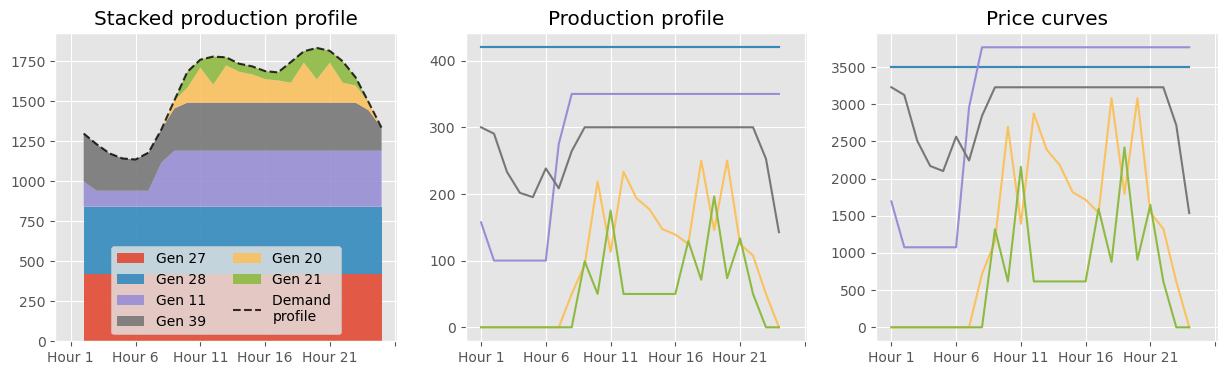

In [18]:
generators_turned_on = on_off.sum(axis=1) != 0

system.pmax['index'] = [f'Gen {i}' for i in range(1, system.N_g+1)]
system.pmax = system.pmax.set_index('index')

system.pmin['index'] = [f'Gen {i}' for i in range(1, system.N_g+1)]
system.pmin = system.pmin.set_index('index')

# Check if power balance equation is satisfied 
power_balance = pd.DataFrame(
    [system.demand_profile.sum(axis=1).values, power.sum(axis=0).values, eps.flatten(), delta.flatten(), (eps + delta).flatten()], 
    index=['demand', 'power', 'eps', 'delta', 'slack_sum'
]).T
assert np.allclose(power_balance['demand'], power_balance[['power', 'eps', 'delta']].sum(axis=1)), 'Power balance equation not satisfied !'

power['total_production'] = power[generators_turned_on].cumsum(axis=1)['Hour 24']


fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False, sharex=True)
axs[0].stackplot(
    np.arange(1, 25), 
    power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production'), 
    labels=power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production').index,
    alpha=0.9,
)
axs[0].plot(np.arange(1,25), power_balance['demand'], color='k', ls='--', alpha=0.8, label='Demand \nprofile')
axs[0].set_title('Stacked production profile')
axs[0].legend(loc='lower center', ncols=2)

power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production').T.plot(title='Production profile', ax=axs[1], legend=False)
cost['total_production'] = power['total_production']
cost[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production').T.plot(title='Price curves', ax=axs[2], legend=False)

plt.show()

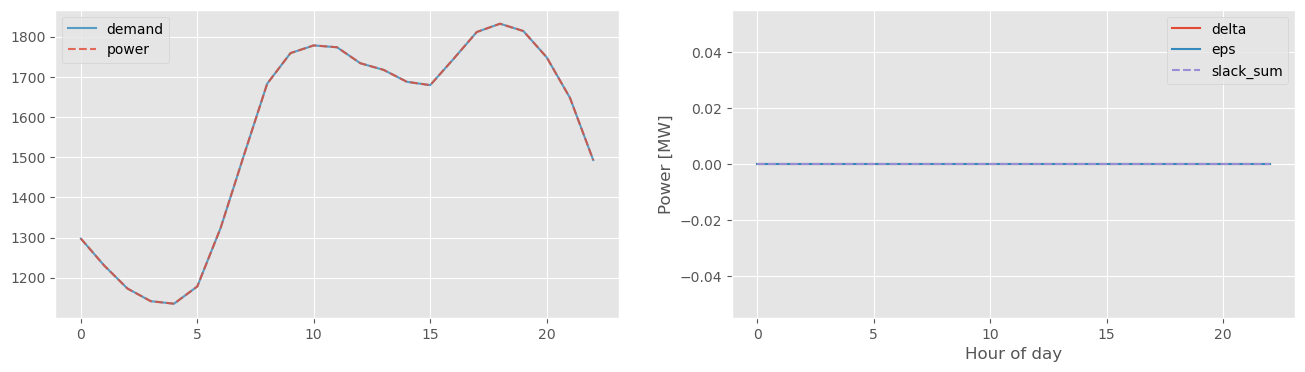

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4)) 
power_balance[:-1].plot(y=['demand'], color='C1', ls='-', alpha=0.8, ax=axs[0])
power_balance[:-1].plot(y=['power'], color='C0', ls='--', alpha=0.8, ax=axs[0])
power_balance[:-1].plot(y=['delta', 'eps'],      ax=axs[1])
power_balance[:-1].plot(y='slack_sum', ls='--',  ax=axs[1])
plt.xlabel('Hour of day')
plt.ylabel('Power [MW]')
plt.show()

Total cost of the system:  357556.62408468715


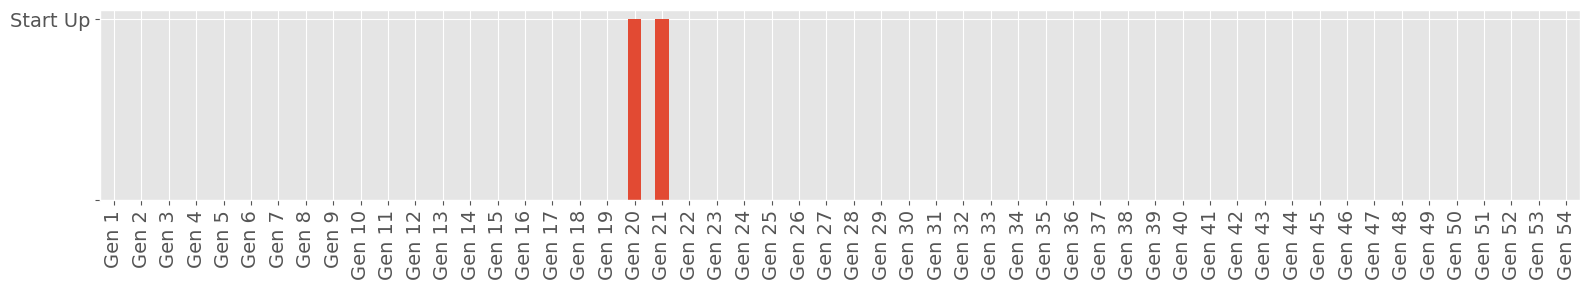

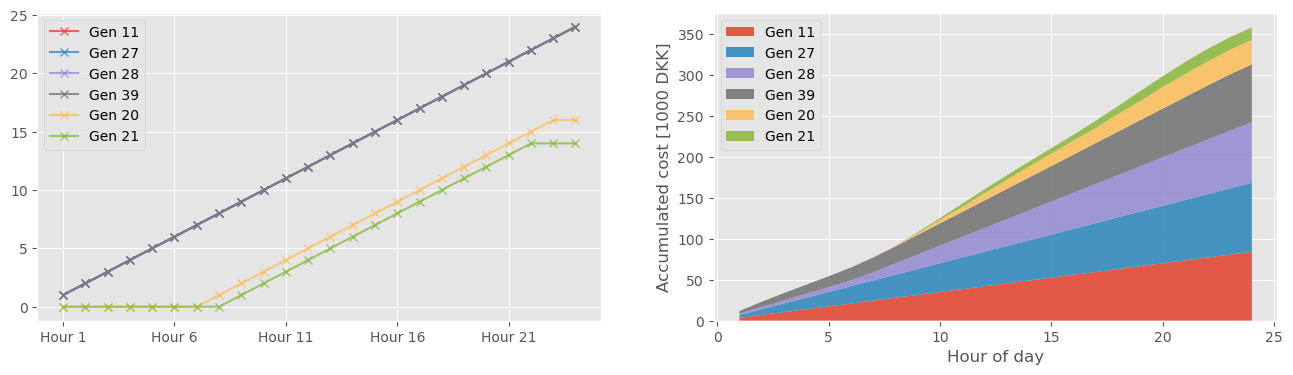

,Hour 6,Hour 7,Hour 8,Hour 9,Hour 10,Hour 11,Hour 12,Hour 13,Hour 14,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24
Gen 20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gen 21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
print("Total cost of the system: ", sum(cost.iloc[:, :-1].values.flatten()))

# Shwo start up status
start_up.sum(axis=1).plot(kind='bar', figsize=(16, 3))
plt.yticks([0, 1], ['', 'Start Up'], fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

### Create production cost curves
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
generators_turned_on = on_off.sum(axis=1) != 0

# Visalize when the generators are turned on
on_off[generators_turned_on].cumsum(axis=1).sort_values(by='Hour 24', ascending=False).T.plot(ax=axs[0], ls='-', marker='x', alpha=0.8)

# Visualize the cost of the system for each turned on generator
axs[1].stackplot(
    np.arange(1, 25), 
    cost.iloc[:, :-1][generators_turned_on].cumsum(axis=1).sort_values(by='Hour 24', ascending=False) / 1000, 
    labels=cost.iloc[:, :-1][generators_turned_on].sort_values(by='Hour 24', ascending=False).index,
    alpha=0.9,
)
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Hour of day')
axs[1].set_ylabel('Accumulated cost [1000 DKK]')
plt.show()

start_up[start_up.sum(axis=1) != 0].iloc[:, 5:]

### Finding active constraints

In [21]:
constraints = pd.DataFrame([{
    'constr_type': c.ConstrName.split('[')[0] if '[' in c.ConstrName else c.ConstrName, 
    'constr_level': '[' + c.ConstrName.split('[')[1] if '[' in c.ConstrName else '-', 
    'constraint_slack': c.Slack, 
    'rhs': c.getAttr('rhs')
} for c in system.model.getConstrs()])

In [22]:
grouped_constraints = {}
for name in tqdm(constraints['constr_type'].unique()):
    grouped_constraints[name] = constraints.query('constr_type == @name').reset_index(drop=True)

line_flow_limits = grouped_constraints['pos_line_flow_limit']
line_flow_limits['l'] = line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[0]))
line_flow_limits['t'] = line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[1]))

print((line_flow_limits.constraint_slack < 1e-3).sum())
slack_line_vals_pos = line_flow_limits['constraint_slack'] - line_flow_limits['rhs']
line_flow_limits

100%|██████████| 4464/4464 [00:00<?, ?it/s]

0


,constr_type,constr_level,constraint_slack,rhs,l,t
0,pos_line_flow_limit,"[0,0]",181.809822,182.074869,0,0
1,pos_line_flow_limit,"[1,0]",187.422726,187.157679,1,0
2,pos_line_flow_limit,"[2,0]",520.040732,518.744275,2,0
3,pos_line_flow_limit,"[3,0]",193.907642,193.304826,3,0
4,pos_line_flow_limit,"[4,0]",154.555887,155.650972,4,0
...,...,...,...,...,...,...
4459,pos_line_flow_limit,"[181,23]",183.824637,172.991056,181,23
4460,pos_line_flow_limit,"[182,23]",500.000000,500.000000,182,23
4461,pos_line_flow_limit,"[183,23]",172.293175,172.293175,183,23
4462,pos_line_flow_limit,"[184,23]",144.347178,121.849531,184,23


In [23]:
grouped_constraints = {}
for name in tqdm(constraints['constr_type'].unique()):
    grouped_constraints[name] = constraints.query('constr_type == @name').reset_index(drop=True)

line_flow_limits = grouped_constraints['neg_line_flow_limit']
line_flow_limits['l'] = line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[0]))
line_flow_limits['t'] = line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[1]))

print((line_flow_limits.constraint_slack < 1e-3).sum())
slack_line_vals_neg = line_flow_limits['constraint_slack'] - line_flow_limits['rhs']
line_flow_limits

100%|██████████| 4464/4464 [00:00<?, ?it/s]

4464


,constr_type,constr_level,constraint_slack,rhs,l,t
0,neg_line_flow_limit,"[0,0]",-168.190178,-167.925131,0,0
1,neg_line_flow_limit,"[1,0]",-162.577274,-162.842321,1,0
2,neg_line_flow_limit,"[2,0]",-479.959268,-481.255725,2,0
3,neg_line_flow_limit,"[3,0]",-156.092358,-156.695174,3,0
4,neg_line_flow_limit,"[4,0]",-195.444113,-194.349028,4,0
...,...,...,...,...,...,...
4459,neg_line_flow_limit,"[181,23]",-166.175363,-177.008944,181,23
4460,neg_line_flow_limit,"[182,23]",-500.000000,-500.000000,182,23
4461,neg_line_flow_limit,"[183,23]",-177.706825,-177.706825,183,23
4462,neg_line_flow_limit,"[184,23]",-205.652822,-228.150469,184,23


In [32]:
np.allclose(abs(slack_line_vals_pos), abs(slack_line_vals_neg))

True

In [73]:
pos_val = slack_line_vals_neg.values.reshape(24,186)
neg_val = slack_line_vals_neg.values.reshape(24,186)

res_aux = np.concatenate((pos_val, neg_val), axis=1)
df_test = pd.DataFrame(res_aux)

df_test.to_csv(f'saved_active_constraints.csv', index=False, header=False, mode='a')
#print(slack_line_vals_neg)

0       -0.265047
1        0.265047
2        1.296458
3        0.602816
4       -1.095085
          ...    
4459    10.833581
4460     0.000000
4461     0.000000
4462    22.497647
4463   -22.497647
Length: 4464, dtype: float64


<a class="anchor" id="machine-learning"></a>
## 4. Can we solve the problem using machine learning?

In [25]:
# OUTPUT: binary generator on/off status
# OUTPUT: active constraints (on transmission lines)

# INPUT: load profile
# INPUT: demand
# INPUT: time (hours)
# INPUT: ramping up/down
# INPUT: minimum on/off time
# INPUT: cost of operation
# INPUT: cost of start-up

In [26]:
#pd.concat([UT, DT], axis=1)

In [27]:
# AUC curve
# heatmap

<a class="anchor" id="extra"></a>
## 5. Extra